<a href="https://colab.research.google.com/github/sarthak-314/Book-Recommender-System/blob/master/Data%20Cleaning%20%2B%20EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA CLEANING + EXPLORATORY DATA ANALYSIS**
***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
DF_PATH = './Colab Notebooks/CADABRA/Recommender System/goodreads-10k'
ratings = pd.read_csv(os.path.join(DF_PATH, 'ratings.csv'))
books = pd.read_csv(os.path.join(DF_PATH, 'books.csv'))
book_tags = pd.read_csv(os.path.join(DF_PATH, 'book_tags.csv'))
books = pd.read_csv(os.path.join(DF_PATH, 'books.csv'))
books = pd.read_csv(os.path.join(DF_PATH, 'books.csv'))

In [ ]:
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
ratings = ratings.head(1000)
ratings['movie_id'] = ratings.book_id
ratings.head()

,user_id,book_id,rating,movie_id
0,1,258,5,258
1,2,4081,4,4081
2,2,260,5,260
3,2,9296,5,9296
4,2,2318,3,2318


In [ ]:
TOTAL_USERS, TOTAL_BOOKS = ratings.user_id.nunique(), ratings.book_id.nunique()

In [ ]:
ratings = ratings.to_numpy()

Both user_id and book_id start from 1. 

Subtracting 1 guarantees that the ID corresponds to specific row and column indexes of the sparse ratings matrix.

In [ ]:
ratings[:, 0] -= 1
ratings[:, 1] -= 1

In [ ]:
import tensorflow.compat.v1 as tf
tf.enable_eager_execution()
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)


In [ ]:
user_ids, book_ids, ratings_by_users = zip(*ratings)

indices = np.stack([user_ids, book_ids], axis=-1)
values  = ratings_by_users
dense_shape = [TOTAL_USERS, TOTAL_BOOKS]
sparse_rating_matrix = tf.SparseTensor(indices=indices, values=values, dense_shape=dense_shape)

$$
Matrix =
\begin{bmatrix}
3 & 1 & 0 & 4 \\
7  &   0 & 0 & 0
\end{bmatrix}
$$


```
#This matrix would be represented as 
tf.SparseTensor(
  indices=[[0, 0], [0, 1], [1,3]],
  values=[5.0, 3.0, 1.0],
  dense_shape=[2, 4])
```

In [ ]:
user_embeddings = ratings.groupby('user_id')
book_embeddings = ratings.groupby('book_id')

In [ ]:
user_embeddings['book_id'].count()

user_id
1      8
2     11
4     85
6      1
8     22
9     51
11    25
15    62
18    34
22    47
24    50
25    20
28     2
29     4
31    74
32    68
34    42
40    19
43     4
46    39
49     2
50     2
53    19
54     2
55    11
56     1
58    28
59    22
61    10
62     4
63     5
65    27
66     6
69     7
70    40
72    13
73    89
74    22
75    18
76     4
Name: book_id, dtype: int64

In [ ]:
sparse_rating_matrix

In [ ]:
def sparse_mean_squared_error(sparse_rating_matrix, user_embeddings, book_embeddings):
    predictions = tf.gather_nd(
      tf.matmul(user_embeddings, book_embeddings, transpose_b=True),
      indices=sparse_rating_matrix.indices)
    loss = tf.losses.mean_squared_error(sparse_rating_matrix.values, predictions)
    return loss

In [ ]:
#Random values 
embedding = 3
U = tf.Variable(tf.random_normal(
      [sparse_rating_matrix.dense_shape[0], embedding], stddev=1.))
#40 people has a shape of (40, 3)
V = tf.Variable(tf.random_normal(
      [sparse_rating_matrix.dense_shape[1], embedding], stddev=1.))
#603 books has a shape of (603, 3)

In [ ]:
sparse_mean_squared_error(sparse_rating_matrix, U, V)

<tf.Tensor 'mean_squared_error_2/value:0' shape=() dtype=float32>

In [ ]:
tf.gather(U, sparse_rating_matrix.indices[:,0])

<tf.Tensor 'GatherV2:0' shape=(1000, 3) dtype=float32>

In [ ]:
# Alternate Solution (Asympotically better)
def sparse_mean_square_error(sparse_ratings, user_embeddings, book_embeddings):
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(book_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

I got the model code from a [colab notebook](https://colab.research.google.com/github/google/eng-edu/blob/master/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=O3bcgduFo4s6).

TensorFlow 1. X requires users to manually stitch together an abstract syntax tree (the graph).

In [ ]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

**BUILD MODEL**

In [ ]:
df = reviews.head(100)

NameError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(ratings.head(100))
sparse_tr = tf.SparseTensor(
    indices=df_train[['user_id', 'book_id']].values, 
    values=df_train.rating.values, 
    dense_shape=[df_train.user_id.nunique(), df_train.book_id.nunique()]
)
sparse_ts = tf.SparseTensor(
    indices=df_test[['user_id', 'book_id']].values, 
    values=df_test.rating.values, 
    dense_shape=[df_test.user_id.nunique(), df_test.book_id.nunique()]
)
embedding_dim = 3

#Initialize the embeddings with a normal distribution
U = tf.Variable(tf.random_normal([sparse_tr.dense_shape[0], embedding_dim]))
B = tf.Variable(tf.random_normal([sparse_ts.dense_shape[0], embedding_dim]))
train_loss = sparse_mean_squared_error(sparse_tr, U, B)
test_loss = sparse_mean_squared_error(sparse_ts, U, B)

embeddings = {
    'user_id':U, 
    'book_id':B
}
metrics = {
    #ERROR
    'train_loss': train_loss, 
    'test_loss': test_loss
}
model = CFModel(embeddings, train_loss, [metrics])

In [ ]:
train_loss

<tf.Tensor 'mean_squared_error_25/value:0' shape=() dtype=float32>

In [ ]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [ ]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = ratings_df[['user_id', 'movie_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [ ]:
model = build_model(ratings.head(100))

In [ ]:
ratings.dtypes

user_id     int64
book_id     int64
rating      int64
movie_id    int64
dtype: object

In [ ]:
model.train()

InvalidArgumentError: ignored

In [ ]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


 iteration 100: train_error=0.000000, test_error=12.729753

[{'test_error': 12.729753, 'train_error': 1.4947664e-08}]

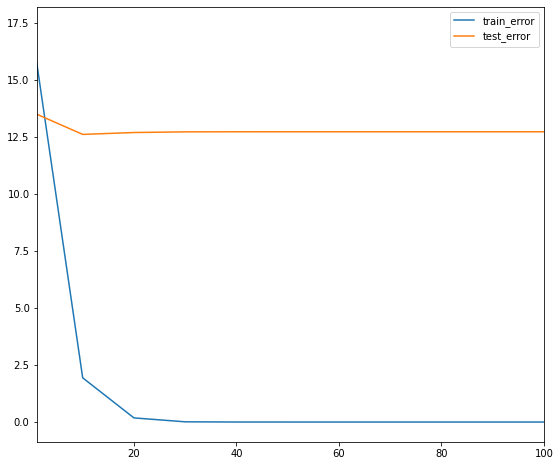

In [ ]:
x.train()

In [ ]:
rating.head

In [ ]:
model.embeddings

{'book_id': None, 'user_id': None}

In [ ]:
model.train()

AttributeError: ignored

In [ ]:
# Build the CF model and train it.
model = build_model(ratings, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10.)

NameError: ignored

In [ ]:
mDOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

In [ ]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
ratings.head()

,user_id,book_id,rating,movie_id
0,1,258,5,258
1,2,4081,4,4081
2,2,260,5,260
3,2,9296,5,9296
4,2,2318,3,2318


In [ ]:
ratings.dtypes

user_id     int64
book_id     int64
rating      int64
movie_id    int64
dtype: object

In [ ]:
user_recommendations(model, measure=COSINE, k=5)

NameError: ignored

Google Cloud article uses WALS algorithm but it's not supported in TF 2

In [ ]:
def build_rating_sparse_tensor(ratings_df):
  """
  Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
  Returns:
    A tf.SparseTensor representing the ratings matrix.
  """
  indices = 
  values =

  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

In [ ]:

# Download MovieLens data.
print("Downloading movielens data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info'))

# Load each data set (users, movies, and ratings).
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    'ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    'ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_cols].sum().to_dict()

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'
